<div style='text-align: center;'>
<img src="../images/math60082-banner.png" alt="image" width="80%" height="auto">
</div>

# Lab Class - Week 7

## Dr P. V. Johnson
## Department of Mathematics

# Demo 7.1: Binomial Trees

The two most popular models for using binomial trees to price options are 
- Cox, Ross and Rubinstein (1977) (CRR for short) whose extra degree of freedom is to set
$$
ud=1
$$
thus
$$
u=e^{\sigma \sqrt{\Delta t}},\quad d=e^{-\sigma\sqrt{\Delta t}},\quad 
q=\frac{e^{r\Delta t}-d}{u-d}
$$

- Rendleman and Bartter (1979) who choose:
$$q=\frac12$$
and so 
$$u=e^{(r-\tfrac12\sigma^2)\Delta t+\sigma\sqrt{\Delta t}},\quad 
d=e^{(r-\tfrac12\sigma^2)\Delta t-\sigma \sqrt{\Delta t}}.\quad
$$

We wish to generate a stock price tree, so denote the value of the underlying asset after timestep $i$ and upstate $j$ by $S_{ij}$ and we have that:
$$S_{ij}=S_0u^jd^{i-j}$$

In [1]:
import matplotlib.pyplot as plt
import numpy

 First declare and initialise the Black Scholes parameters for your chosen problem. Here we are going to value a 
Black Scholes vanilla European call option with, $S_0=100$, $X=100$, $T=1$, $r=0.06$ and $\sigma=0.2$, so declare variables
for each of these. Next add in an integer to store the number of steps in the tree and call it $n$.
Finally add in some local variable to describe the tree, so we have the timestep length $dt$,
$u$, $d$ and $q$. 

In [4]:
# stock parameters
S_0 = 100 # initial stick price

# call option contract parameters
X = 100 # strike price
T = 1.0 # time to expiry

# market parameters
r = 0.06 # risk free interest rate

# model parameters
sigma = 0.2 #  volatility

# steps in the tree
n=3

# local stuff
dt = T/n
u = numpy.exp(sigma*numpy.sqrt(dt))
d = 1./u
q = (numpy.exp(r*dt) - d)/(u-d)
print(" dt:=",dt,"; u:=",u,"; d:=",d,"; q:=",q)

 dt:= 0.3333333333333333 ; u:= 1.1224009024456676 ; d:= 0.8909472522884107 ; q:= 0.5584448015856557


Next we need to create some storage for the values of the stock at each node in the tree. Declare an array `stock_tree` with shape $(n+1)\times(n+1)$, 
into which we will place our stock price nodes.
 

In [5]:
stock_tree = numpy.zeros(shape=(n+1,n+1))
stock_tree

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Now use a `for` loop and the function `numpy.pow` to input the value of the stock at each node in the tree, 
where $S_{i,j} \rightarrow $`stock_tree[i][j]`.

In [6]:

for i in range(0,n+1):
    for j in range(0,i+1):
        stock_tree[i][j] = S_0*pow(u,j)*pow(d,i-j)
stock_tree

array([[100.        ,   0.        ,   0.        ,   0.        ],
       [ 89.09472523, 112.24009024,   0.        ,   0.        ],
       [ 79.37870064, 100.        , 125.97837858,   0.        ],
       [ 70.72223522,  89.09472523, 112.24009024, 141.39824581]])

Compare the values with those from the example in the lectures.

Let us generate a simple example so that we can compare results at every stage to something that we can work out on paper. 
 This is an important idea in debugging, to solve the problem and do all of your bug checking on a small scale **before** attempting the full problem.

Now declare an array which shall hold the values of the option and set it to the same shape as `stock_tree`. Here we use the same relation

$V_{i,j} \rightarrow $`value_tree[i][j]`

In [7]:
value_tree = numpy.zeros(shape=(n+1,n+1))

Now fill in the final values of the tree, given that we have already first generated the stock tree:
 $$
 V_{n,j}=payoff(S_{n,j}),
 $$
 where payoff is the appropriate function for the type of option we are solving for.

In [8]:
for j in range(0,n+1):
    value_tree[n][j] = max( stock_tree[n][j] - X , 0.0)
value_tree

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 12.24009024, 41.39824581]])

Now we need to loop **backwards** through the tree to generate the value at each node using the equation:
 $$
 V_{ij}=e^{-r\Delta t}(qV_{i+1,j+1}+(1-q)V_{i+1,j}).
 $$
 

In [10]:
for i in range(n-1,-1,-1):
    for j in range(0,i+1):
        value_tree[i][j] = numpy.exp(-r*dt)*( q*value_tree[i+1][j+1] + (1-q)*value_tree[i+1][j] )
value_tree

array([[11.55197318,  0.        ,  0.        ,  0.        ],
       [ 3.66752722, 18.20398861,  0.        ,  0.        ],
       [ 0.        ,  6.70006449, 27.95851125,  0.        ],
       [ 0.        ,  0.        , 12.24009024, 41.39824581]])

Adjusting binomial tree to solve American options is **extremely** easy!

In [23]:
def americanBinomialTree(S_0,X,T,r,sigma,n):
    
    # local stuff
    dt = T/n
    u = numpy.exp(sigma*numpy.sqrt(dt))
    d = 1./u
    q = (numpy.exp(r*dt) - d)/(u-d)
    stock_tree = numpy.zeros(shape=(n+1,n+1))
    value_tree = numpy.zeros(shape=(n+1,n+1))
    for i in range(0,n+1):
        for j in range(0,i+1):
            stock_tree[i][j] = S_0*pow(u,j)*pow(d,i-j)
    for j in range(0,n+1):
        value_tree[n][j] = max( X - stock_tree[n][j] , 0.0)
    for i in range(n-1,-1,-1):
        for j in range(0,i+1):
            value_tree[i][j] = numpy.exp(-r*dt)*( q*value_tree[i+1][j+1] + (1-q)*value_tree[i+1][j] )
            value_tree[i][j] = max(value_tree[i][j],X-stock_tree[i][j]) # take the optimal exercise decision
    return value_tree[0][0]

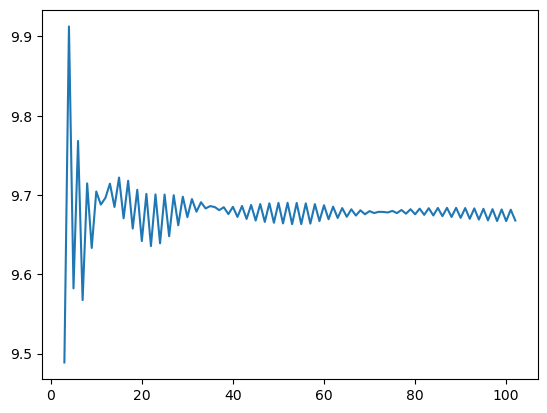

In [24]:
import matplotlib.pyplot as plt

results = 100

S_0 = 92.346

nArray = numpy.zeros(results)
vArray = numpy.zeros(results)
for i in range(results):
    nArray[i] = i + 3
    vArray[i] = americanBinomialTree(S_0,X,T,r,sigma,int(nArray[i]))
plt.plot(nArray,vArray)

# Tasks

- Write `for` loops to move backwards through the vector array caculating the value of the option at each node.
- Print out the tree to screen (with $n=3$) and compare to the simple example from the notes to check your code is working.
- If your values don't match - try to work out why!!
- Now print out the value at $(0,0)$ increasing the number of steps in the tree. Do the results look feasible? Compare them against the exact values from the formula.
- Create a function returning the value of the binomial tree for a set of given parameters.
- Write a code storing two time-levels, and compare (at every stage if needed) with the previous code.
- Is it possible to store just one time-level? Try to write a code for this.
- Do you notice any difference (time taken for computation) between the codes with different storage requirements?
- Try speeding the code up with `numba` or `cython` libraries

# Demo 7.2: Evaluating Convergence Properties

Taking the code from last time, you could write your binomial code to take the payoff as an argument to the function:

In [7]:
def binomialBlackScholes(S_0,T,r,sigma,payoff,n):
    # setup
    dt = T/n
    u = numpy.exp(sigma*numpy.sqrt(dt))
    d = 1./u
    q = (numpy.exp(r*dt) - d)/(u-d)
    stock_tree = numpy.zeros(shape=(n+1,n+1))
    value_tree = numpy.zeros(shape=(n+1,n+1))
    for i in range(0,n+1):
        for j in range(0,i+1):
            stock_tree[i][j] = S_0*pow(u,j)*pow(d,i-j)
    # terminal conditions
    for j in range(0,n+1):
        value_tree[n][j] = payoff(stock_tree[n][j])
    # solve
    for i in range(n-1,-1,-1):
        for j in range(0,i+1):
            value_tree[i][j] = numpy.exp(-r*dt)*( q*value_tree[i+1][j+1] + (1-q)*value_tree[i+1][j] )
    return value_tree[0][0]

An example using this code would be:

In [8]:
callPayoff = lambda S:max(S-X,0.0)

In [9]:
print(binomialBlackScholes(S_0,T,r,sigma,callPayoff,3))

11.551973176964253


Now we wish to investigate what happens when $N$ is increasing. Write a loop in your code to output
the results of $N$ and the resulting value $V$ to some arrays so they can be plotted.

In [10]:
no_of_results = 491

nArray = numpy.zeros(no_of_results)
vArray = numpy.zeros(no_of_results)
for i in range(0,no_of_results):
    nArray[i] = 10+i
    vArray[i] = binomialBlackScholes(S_0,T,r,sigma,callPayoff,int(nArray[i]))

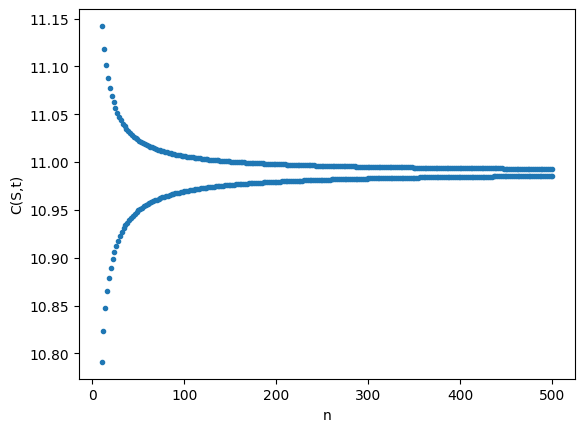

In [11]:
plt.xlabel('n')
plt.ylabel('C(S,t)')
plt.plot(nArray,vArray,'.')

The pattern can be explained by realising that the nodes at terminal time will either be placed exactly on the strike price, or above/below depending on whether the 
number of steps is odd or even.  We will see quite a different pattern if you choose $S_0\neq X$, so for example set $S_0=97.3467$ in your code and rerun the results.

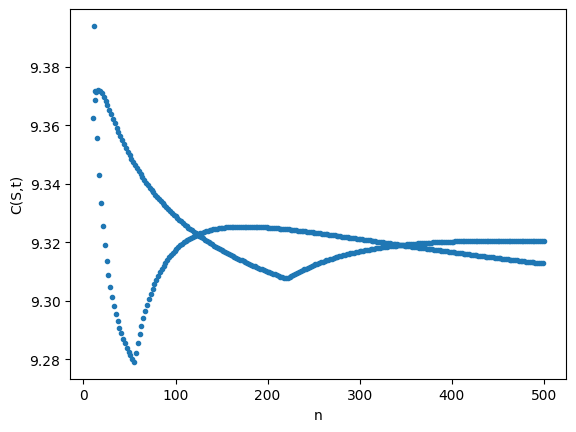

In [12]:
no_of_results = 491

nArray = numpy.zeros(no_of_results)
vArray = numpy.zeros(no_of_results)
for i in range(0,no_of_results):
    nArray[i] = 10+i
    vArray[i] = binomialBlackScholes(97.3467,T,r,sigma,callPayoff,int(nArray[i]))
plt.xlabel('n')
plt.ylabel('C(S,t)')
plt.plot(nArray,vArray,'.')

This time we see *humps* as well as an odd-even effect. The humps are
again caused by the positioning of the grid nodes relative to the strike price. Although the convergence of the tree is $O(1/n)$, the humps make it very difficult to achieve high 
accuracy. There are several papers that try to address this, one way is to adjust the position of the nodes and others try to smooth the payoff at maturity to gain smoother convergence.

# Tasks

- Can you estimate the convergence rate?
- Assume that the payoff of the option is
$$
V(S,T) = \left\{\begin{array}{cc}
0 & \text{ if } S<X\\
1 & \text{ if } S\geq X
\end{array}\right.
$$
Plot out the solution to this problem with a binomial tree for different value s of $N$, in the case where $S_0=X$ and $S_0\neq X $. Can you explain the results?
- Now try setting
$$
V_{n,j} = \left\{\begin{array}{ccc}
0 & \text{ if } &S_j^N<2X - S^N_{j+1}\\
&&\\
\frac{S^N_{j+1} + S^N_j - 2X}{S^N_{j+1}-S^N_{j-1}} & \text{ if } &2X - S^N_{j+1}\leq  S_j^N  \leq 2X-S^N_{j-1} \\
&&\\
1 & \text{ if } &S_j^N > 2X-S^N_{j-1}
\end{array}\right.
$$
and plot the results again. How has it changed? See Heston and Zhou (2000) for more details on how to derive this formula.


## References

Cox, J. C., Ross, S. A. & Rubinstein, M. (1979). "Option pricing: A simplified approach", *Journal of financial Economics* **7**(3):229--263.

Heston, S. & Zhou, G. (2000). "On the rate of convergence of discrete-time contingent claims", *Mathematical Finance* **10**(1):53--75.

Joshi, M. S. (2007). "The convergence of binomial trees for pricing the american put", *Available at SSRN 1030143*.

Leisen, D. P. & Reimer, M. (1996). "Binomial models for option valuation-examining and improving convergence", *Applied Mathematical Finance* **3**(4):319--346.

Rendleman, R. J. & Bartter, B. J.  (1979). "Two-state option pricing", *The Journal of Finance* **34**(5):1093--1110.
